In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, expon, beta
%matplotlib inline

sns.set(font_scale=2)

# 1. Критерий Манна-Уитни

| Версия сайта | Общее количество визитов | Конверсия | Конверсия в процентах |
|--------------|--------------------------|-----------|-----------------------|
|  Version 1   | 10283                    | 3714      | 36%                   |
|  Version 2   | 2742                     | 1587      | 58%                   |
| Version 3    | 2747                     | 1652      | 60%                   |
| Version 4    | 3180                     | 1717      | 54%                   |
| Version 5    | 2064                     | 1348      | 65%                   |

Какой же вариант сайта лучше, а какие статистически объяснимые девиации от их своеобразных средних уровней?

##### Критерий Манна-Уитни(рабоче-крестьянский алгоритм)

Критерий Манна-Уитни используется для сравнения средних двух групп.

Cтатистика U считается следующим образом для двух выборок X и Y: 
  0. $U_1 = 0$
  1. Берутся все пары из двух выборок: $(x_i, y_i)$;
  2. Если $x_i > y_i$, то $U_1 += 1$;
  3. Если $x_i == y_i$, то $U_1 += 0.5$;
  4. Аналогично считается $U_2$ по парам $(y_i, x_i)$;
  5. $U = min(U_1, U_2)$
 
При больших размерах выборки:

$$U \sim N\left(\frac{mn}{2}, \frac{mn(n + m + 1)}{12}\right)$$

При большой выборке и __возможных ничьих__ $\sigma$ считается по-другому:

$$
\sigma = \sqrt{ \frac{nm}{(m + n) (m + n - 1)} \cdot \left[ \frac{(m + n)^3 - (m + n)}{12} - \sum \frac{t_j^3 - t_j}{12} \right]},
$$

где $t_j$ -- количество ничьих.


#### Замечательность рангового теста Манна-Уитни: 

  * работает для всех типов данных данных: дискретные, распределённые не нормально;
  * не обращает внимание на outliers;
  * связан с ROC-AUC.
  
  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1120984/

In [2]:
data = np.array([
    [10283, 3714],
    [2742, 1587],
    [2747, 1652],
    [3180, 1717],
    [2064, 1348]
])

alpha = 0.05 / 5 # 5 потому что бонферотти

In [3]:
def mann_whitney(conversion_1, conversion_2, alpha=0.05):
    """
    conversion = (N, n), где N -- общее число визитов, n -- конверсия
    True => H_0 отклоняется => средние не равны
    """
    U_1 = conversion_1[1] * (conversion_2[0] - conversion_2[1]) + conversion_1[1] * conversion_2[1] / 2 + (conversion_2[0] - conversion_2[1]) * (conversion_1[0] - conversion_1[1]) / 2
    U_2 = conversion_2[1] * (conversion_1[0] - conversion_1[1]) + conversion_1[1] * conversion_2[1] / 2 + (conversion_2[0] - conversion_2[1]) * (conversion_1[0] - conversion_1[1]) / 2
    
    mean = conversion_1[0] * conversion_2[0] / 2
    N = conversion_1[0] + conversion_2[0]
    mn = conversion_1[0] * conversion_2[0]
    t_1 = (conversion_1[0] - conversion_1[1]) + (conversion_2[0] - conversion_2[1])
    t_2 = conversion_1[1] + conversion_2[1]
    std = (mn / (N * (N - 1))) * ((N**3 - N) / 12 - 
                                 (t_1**3 - t_1) / 12 - 
                                 (t_2**3 - t_2) / 12 )
    std = np.sqrt(std)
    z = np.abs(min(U_1, U_2) - mean) / std 
    return z, z > norm.ppf(1 - alpha / 2)

### Тест Вальда

Статистика на которую мы смотрим:

$$T = \frac{\hat{p}_1 - \hat{p}_2}{\hat{se}}$$

Где дисперсия считается следующим образом:

$$\hat{se}^2 = \hat{se}_1^2 + \hat{se}_2^2$$

$$\hat{se}_1^2 = \frac{p_1 (1 - p_1)}{n_1}$$

Тестовая статистика имеет следующее распределение:

$$T \sim \mathcal{N}(0, 1)$$

In [4]:
from scipy.stats import norm
def wald_test(conversion_1, conversion_2, alpha=0.05):
    """
    Проверяется Вальд для Бернулли. 
    True => H_0 отклоняется => средние не равны.
    """
    p_1 = conversion_1[1] / conversion_1[0]
    p_2 = conversion_2[1] / conversion_2[0]
    se_1 = np.sqrt(p_1 * (1 - p_1) / conversion_1[0])
    se_2 = np.sqrt(p_2 * (1 - p_2) / conversion_2[0])
    se = np.sqrt(se_1**2 + se_2**2)
    return np.abs((p_1 - p_2) / se), np.abs((p_1 - p_2) / se) > norm.ppf(1 - alpha / 2)

In [5]:
from collections import defaultdict
results_mww = defaultdict(lambda: defaultdict(bool))
z_mww = []
for i in np.arange(len(data)):
    for j in np.arange(len(data)):
        z, flag = mann_whitney(data[i], data[j], alpha=alpha)
        print(z)
        z_mww.append(z)
        results_mww[i][j] = flag
        if results_mww[i][j]:
            print('Версия сайта {} с конверсией {:.2f} статистически отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                              data[i][1] / data[i][0],
                                                                                              j+1,
                                                                                              data[j][1] / data[j][0]))
        else:
            print('Версия сайта {} с конверсией {:.2f} статистически не отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                                         data[i][1] / data[i][0], 
                                                                                                         j+1,
                                                                                                         data[j][1] / data[j][0]))
        print()

0.0
Версия сайта 1 с конверсией 0.36 статистически не отличается от версии 1 с конверсией 0.36

20.607089406964572
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 2 с конверсией 0.58

22.72339288118447
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 3 с конверсией 0.60

17.95738651374319
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 4 с конверсией 0.54

24.60758946032845
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 5 с конверсией 0.65

20.607089406964572
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 1 с конверсией 0.36

0.0
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 2 с конверсией 0.58

1.7027432222795187
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 3 с конверсией 0.60

3.000484275270596
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 4 с конверсией 0.54

5.230413282646482
Версия сайта 2 с конверсией 0.58 ст

In [6]:
from collections import defaultdict
results_wald = defaultdict(lambda: defaultdict(bool))
z_wald = []
for i in np.arange(len(data)):
    for j in np.arange(len(data)):
        z, flag = wald_test(data[i], data[j], alpha=alpha)
        print(z)
        z_wald.append(z)
        results_wald[i][j] = flag
        if results_wald[i][j]:
            print('Версия сайта {} с конверсией {:.2f} статистически отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                              data[i][1] / data[i][0],
                                                                                              j+1,
                                                                                              data[j][1] / data[j][0]))
        else:
            print('Версия сайта {} с конверсией {:.2f} статистически не отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                 data[i][1] / data[i][0],
                                                                                 j+1,
                                                                                 data[j][1] / data[j][0]))
        print()

0.0
Версия сайта 1 с конверсией 0.36 статистически не отличается от версии 1 с конверсией 0.36

20.620895355293204
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 2 с конверсией 0.58

22.93344269021802
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 3 с конверсией 0.60

17.826653746799323
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 4 с конверсией 0.54

25.388815771018628
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 5 с конверсией 0.65

20.620895355293204
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 1 с конверсией 0.36

0.0
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 2 с конверсией 0.58

1.70333528052776
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 3 с конверсией 0.60

3.0051027852151844
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 4 с конверсией 0.54

5.273099827112846
Версия сайта 2 с конверсией 0.58 с

/root/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/root/miniconda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/root/miniconda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


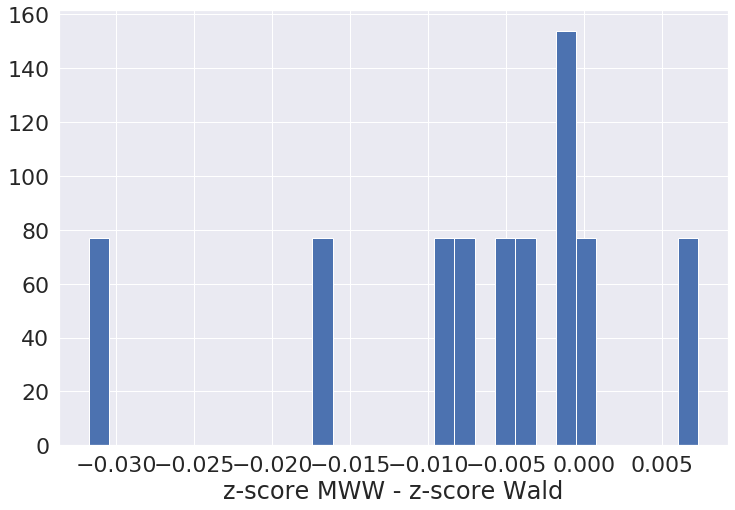

In [7]:
plt.figure(figsize=(12, 8))
plt.hist((np.array(z_mww) - np.array(z_wald)) / np.array(z_mww), bins=30, density=True);
plt.xlabel('z-score MWW - z-score Wald')
plt.show()

### Какие выводы можно сделать?

### В чём разница между Манн-Уитни и Вальдом?

# 2. ROC-AUC

ROC-AUC и статистика Манна-Уитни связаны очень простым соотношением:

$$\mathrm{ROC-AUC} = \frac{U}{n m }$$

$U$ считаеся по вероятностям, которые выдал классификатор, а $n$ и $m$ -- количество положительных и отрицательных примеров.

На игрушечном датасете посмотрим что такое ROC-AUC.

In [8]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from scipy.stats import rankdata, tiecorrect, mannwhitneyu


X, y = make_classification(n_samples=200, n_features=10, n_redundant=8, class_sep=0.9, 
                           n_informative=2, random_state=1337)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1337)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression().fit(X_train, y_train)

y_pred = lr.predict_proba(X_test)[:, 1]

print('ROC-AUC={}'.format(roc_auc_score(y_test, y_pred)))

ROC-AUC=0.9056000000000001


/root/miniconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
y_test_colors = y_test.copy().astype(np.object)
y_test_colors[y_test==0] = ['r']
y_test_colors[y_test==1] = ['g']

y_pred_argsorted = np.argsort(y_pred)


y_pred = y_pred[y_pred_argsorted]
y_test_colors = y_test_colors[y_pred_argsorted]
y_test = y_test[y_pred_argsorted]
X_test = X_test[y_pred_argsorted]

Посчитаем Манна-Уитни с помощью функции из `scipy.stats`.

In [11]:
mannwhitneyu?

In [12]:
mannwhitneyu(y_pred[y_test==1], y_pred[y_test==0], 
             alternative='two-sided')

MannwhitneyuResult(statistic=566.0, pvalue=9.157883328039219e-07)

In [13]:
n = np.sum(y_test==1)  # количество объектов положительного класса
m = np.sum(y_test==0)  # количесво объектов отрицательного класса

Удостверимся в равенстве:

$$\mathrm{ROC-AUC} = \frac{U}{n m }$$

In [14]:
mannwhitneyu(y_pred[y_test==1], y_pred[y_test==0], 
             alternative='two-sided')[0] / (n * m)

0.9056

Отлично!

Теперь для интерпретации ROC-AUC нам потребуется вытащить ранги. 

Ранг это порядок в отсортированном массиве.

In [15]:
ranks = rankdata(y_pred)
pos_ranks = ranks[y_test == 1]

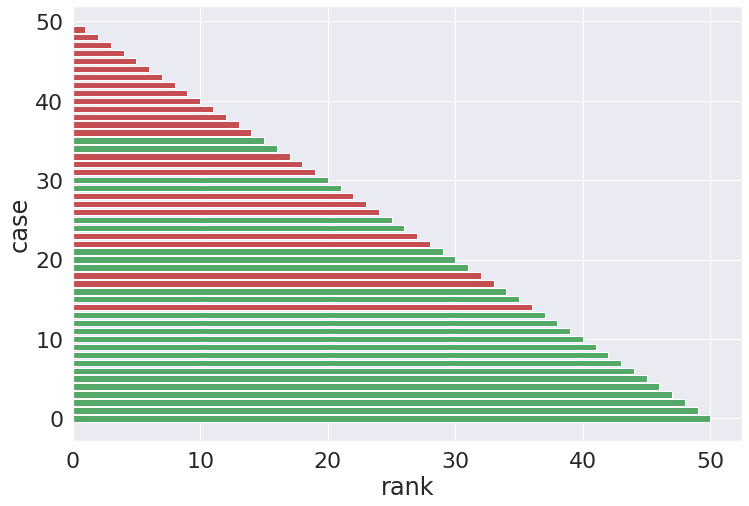

In [16]:
plt.figure(figsize=(12, 8))

plt.barh(np.arange(len(y_pred))[::-1], ranks, color=y_test_colors)

plt.ylabel('case')
plt.xlabel('rank')
plt.show()

In [17]:
x_offset = m + np.arange(1, n + 1) - pos_ranks

In [18]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

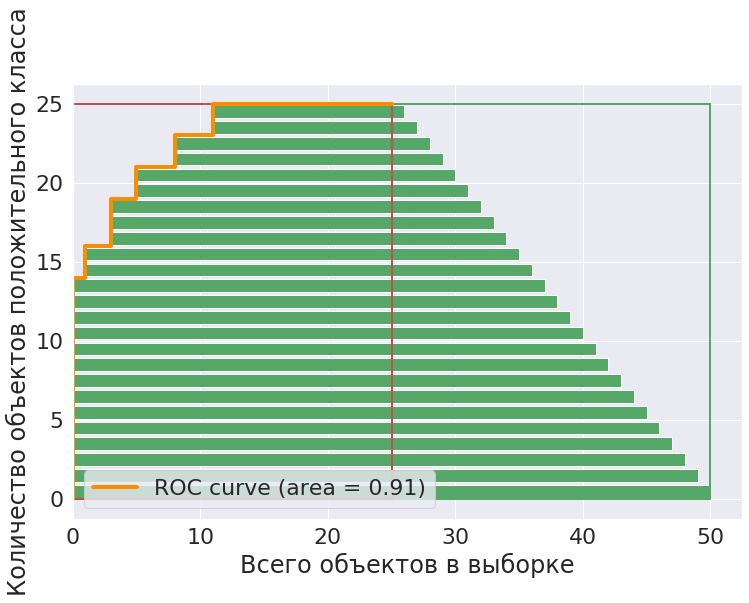

In [19]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 8))
plt.barh(y=np.arange(n)[::-1] + 0.5, width=pos_ranks, left=x_offset, color='g')
plt.plot(m * fpr, n * tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc, lw=4)
plt.gca().add_patch(plt.Rectangle(xy=(m, 0), edgecolor='g',
                                  height=n, width=n, fill=False, linewidth=2))
plt.gca().add_patch(plt.Rectangle(xy=(0, 0), edgecolor='r',
                                  height=n, width=m, fill=False, linewidth=2))
plt.xlabel('Всего объектов в выборке')
plt.ylabel('Количество объектов положительного класса')
plt.legend(loc='best')
plt.show()

## Применим это к реальной задаче

Прочитаем данные и разобъём их на train/test выборки.

In [60]:
X = pd.read_csv('./cell2celltrain.csv')
msk = np.random.rand(len(X)) < 0.8
X_train = X[msk].copy()
X_test = X[~msk].copy()

columns = ['MonthlyRevenue', 'MonthlyMinutes',
           'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
           'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
           'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
           'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
           'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
           'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
           'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels',
           'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
           'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
           'BuysViaMailOrder', 'RespondsToMailOffers',
           'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
           'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
           'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGroup',
           'OwnsMotorcycle', 'AdjustmentsToCreditRating', 'HandsetPrice',
           'MadeCallToRetentionTeam', 'CreditRating', 'Occupation',
           'MaritalStatus']

Выкинем колонки `'ServiceArea', 'Homeownership', 'PrizmCode'`.

In [61]:
drop_columns = ['ServiceArea', 'Homeownership', 'PrizmCode']

X_train.drop(labels=drop_columns, axis=1, inplace=True)
X_test.drop(labels=drop_columns, axis=1, inplace=True)

Бинарные колонки закодируем как `0/1`.

In [62]:
bin_cols = ['Churn', 'HandsetRefurbished', 'HandsetWebCapable', 'RespondsToMailOffers',
            'TruckOwner', 'RVOwner', 'BuysViaMailOrder', 'OptOutMailings', 'NonUSTravel',
            'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser',
            'OwnsMotorcycle', 'MadeCallToRetentionTeam', 'ChildrenInHH', 'MaritalStatus']
def preprocess_bin_cols(X, cols):
    for col in cols:
        X[col] = X[col].apply(lambda x: 1 if x == 'Yes' else 0)
        
        
preprocess_bin_cols(X_train, bin_cols)
preprocess_bin_cols(X_test, bin_cols)

In [63]:
def ohe(X_train, X_test, col):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

ohe(X_train, X_test, 'CreditRating')
ohe(X_train, X_test, 'Occupation')

Избавимся от NaN-данных.

In [64]:
X_train[X_train == 'Unknown'] = np.nan
X_train.fillna(0, inplace=True)

X_test[X_test == 'Unknown'] = np.nan
X_test.fillna(0, inplace=True)

Переводим в numpy-формат.

In [65]:
y_train = X_train.Churn.values
X_train = X_train[columns].values.astype(float)

y_test = X_test.Churn.values
X_test = X_test[columns].values.astype(float)

In [66]:
lr = LogisticRegression().fit(X_train, y_train)

y_pred = lr.predict_proba(X_test)[:, 1]

print('ROC-AUC={}'.format(roc_auc_score(y_test, y_pred)))

ROC-AUC=0.6162309455062102


In [67]:
y_test_colors = y_test.copy().astype(np.object)
y_test_colors[y_test==0] = ['r']
y_test_colors[y_test==1] = ['g']

y_pred_argsorted = np.argsort(y_pred)

y_pred = y_pred[y_pred_argsorted]
y_test_colors = y_test_colors[y_pred_argsorted]
y_test = y_test[y_pred_argsorted]
X_test = X_test[y_pred_argsorted]

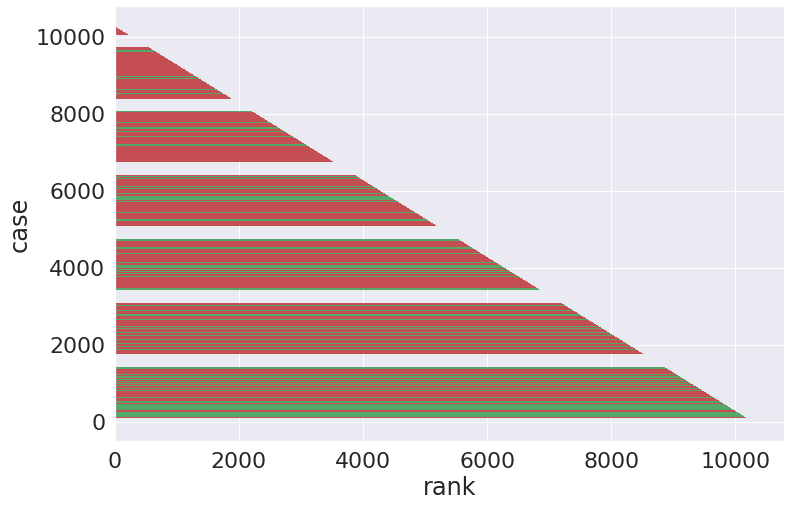

In [72]:
ranks = rankdata(y_pred)
pos_ranks = ranks[y_test == 1]

plt.figure(figsize=(12, 8))

plt.barh(np.arange(len(y_pred))[::-1], ranks, color=y_test_colors, edgecolor='none')

plt.ylabel('case')
plt.xlabel('rank')
plt.show()

In [69]:
n = np.sum(y_test==1)  # количество объектов положительного класса
m = np.sum(y_test==0)  # количесво объектов отрицательного класса

x_offset = m + np.arange(1, n + 1) - pos_ranks

In [70]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

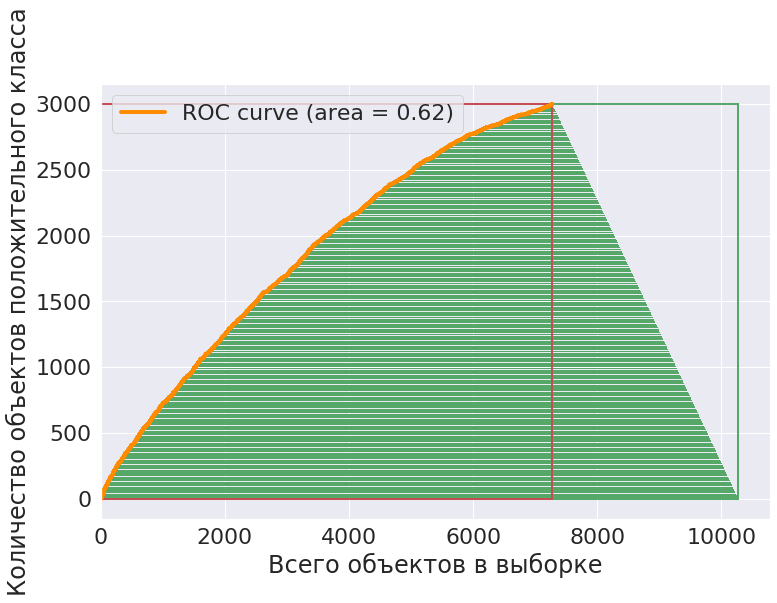

In [73]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 8))
plt.barh(y=np.arange(n)[::-1] + 0.5, width=pos_ranks, left=x_offset, color='g', edgecolor='none')
plt.plot(m * fpr, n * tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc, lw=4)
plt.gca().add_patch(plt.Rectangle(xy=(m, 0), edgecolor='g',
                                  height=n, width=n, fill=False, linewidth=2))
plt.gca().add_patch(plt.Rectangle(xy=(0, 0), edgecolor='r',
                                  height=n, width=m, fill=False, linewidth=2))
plt.xlabel('Всего объектов в выборке')
plt.ylabel('Количество объектов положительного класса')
plt.legend(loc='best')
plt.show()

# 3.2 Три способа посчитать дисперсию ROC-AUC(на самом деле 4)

### Из предельного распределения статистики Манна-Уитни

При больших размерах выборки, как было написано выше:

$$U \sim \mathcal{N}\left(\frac{mn}{2}, \frac{mn(n + m + 1)}{12}\right)$$

то для ROC-AUC предельное распределение будет следующим:

$$ \mathrm{ROC-AUC} \sim \mathcal{N} \left(\frac{1}{2}, \frac{n + m + 1}{12 n m}\right) $$

В данном контексте $n$ и $m$ количество положительных и отрицательных примеров в выборке.

В данном вражении нас интересует только оценка стандартного отклонения:

$$\hat{se} = \sqrt{\frac{n + m + 1}{12 n m}}$$

Замечательностью и слабостью данной формулы является её независимость от $\widehat{AUC}$, т.е. можно использовать для планирования эксперимента при известных априорных распределений на $n$ и $m$.

In [32]:
def roc_auc_variance_from_mann_whitney(n1, n2):
    return (n1 + n2 + 1) / (12 * n1 * n2)

### Метод "Mcneil"(усложнённый вариант метода выше)

https://pubs.rsna.org/doi/10.1148/radiology.143.1.7063747

http://cejsh.icm.edu.pl/cejsh/element/bwmeta1.element.desklight-1f1afc51-6102-491f-a21d-de29ae98ce3b/c/MIBE_T15_z2_36.pdf

![](var_auc.png)

В данном контексте $\theta$ -- "истинный" ROC-AUC.

$$\hat{se} = \sqrt{ \frac{ (\hat{AUC} (1 - \hat{AUC}) + (n - 1)(Q_1 - \hat{AUC}^2) + (m - 1)(Q_2 - \hat{AUC}^2) )() }{n m} }$$

Плюс:
  * учитывает полученное значение AUC.

Минус:
  * сильное предположение о нормальности распределения.

In [33]:
def roc_auc_variance(auc, n1, n2):
    q1 = auc / (2 - auc)
    q2 = 2 * auc**2 / (1 + auc)
    return (auc * (1 - auc) + (n1 - 1) * (q1 - auc**2) + (n2 - 1) * (q2 - auc**2)) / (n1 * n2)

### Метод ДеЛонга 

https://www.ncbi.nlm.nih.gov/pubmed/3203132

Этот метод ещё дополнительно учитывает корреляции между положительным и отрицательными классами.

In [74]:
from compare_auc_delong_xu import delong_roc_variance

In [75]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

models = {
    'LogisticRegression': LogisticRegression(),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

In [76]:
from tqdm import tqdm
auc_var_naives = []
auc_var_params = []
auc_var_delongs = []
aucs = []
model_names = []

for model_name, model in tqdm(models.items()):
    # train model
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    # estimate auc and variance
    auc = roc_auc_score(y_test, y_pred)
    n, m = y_test.sum(), len(y_test) - y_test.sum()
    auc_var_naive = roc_auc_variance_from_mann_whitney(n, m)
    auc_var_param = roc_auc_variance(auc, n, m)
    _, auc_var_delong = delong_roc_variance(y_test, y_pred)
    
    # add stats to lists
    model_names.append(model_name)
    auc_var_naives.append(auc_var_naive)
    auc_var_params.append(auc_var_param)
    auc_var_delongs.append(auc_var_delong)
    aucs.append(auc)
    
auc_var_naives = np.sqrt(np.array(auc_var_naives))
auc_var_params = np.sqrt(np.array(auc_var_params))
auc_var_delongs = np.sqrt(np.array(auc_var_delongs))
aucs = np.array(aucs)

100%|██████████| 3/3 [00:07<00:00,  3.92s/it]


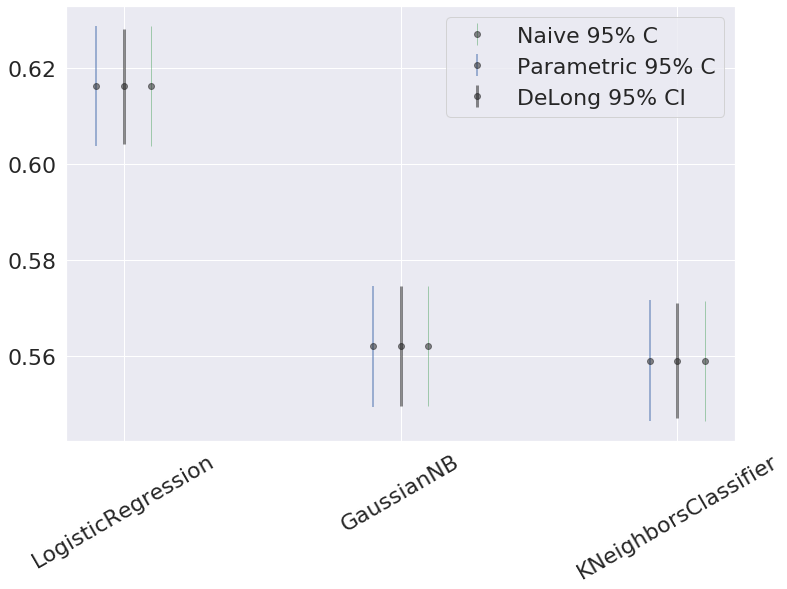

In [77]:
x = np.arange(len(aucs))
plt.figure(figsize=(12, 8))

plt.errorbar(x + 0.1, aucs, 2 * auc_var_naives, fmt='ok', lw=1, alpha=0.5, 
             ecolor='g', label='Naive 95% C')
plt.errorbar(x - 0.1, aucs, 2 * auc_var_params, fmt='ok', lw=2, alpha=0.5, 
             ecolor='b', label='Parametric 95% C')
plt.errorbar(x, aucs, 2 * auc_var_delongs, fmt='ok', lw=3, alpha=0.5, 
             ecolor='k', label='DeLong 95% CI')

plt.xticks(x, model_names, rotation=30)
plt.legend()
plt.show()

### Посмотрим на поведение стандартного отклонения ROC-AUC при маленькой выборке на искуственной задаче

Первая выборка сэмплируется из:

$$x_1 \sim \mathcal{N}(x_1 ; 0, 1)$$

Вторая выборка сэмплируется из:

$$x_2 \sim \mathcal{N}(x_1 ; 2, 1)$$

Тогда идеальный ROC-AUC может быть расчитан следующим образом:

$$\mathrm{ROC-AUC} = p(x_2 > x_1) = p\left(\mathcal{N}(2, 2) > 0\right) = \frac{1}{2} \mathrm{erfc}\left(-\frac{\mu}{\sqrt{2} \sigma}\right) \approx 0.92$$

In [78]:
from scipy.stats import norm
def make_classification(n_samples, mu_1=0, sigma_1=1, mu_2=2, sigma_2=1):
    X_1 = norm.rvs(loc=mu_1, scale=sigma_1, size=n_samples).reshape(-1, 1)
    X_2 = norm.rvs(loc=mu_2, scale=sigma_2, size=n_samples).reshape(-1, 1)
    X = np.concatenate([X_1, X_2], axis=0)
    Y = np.ones_like(X)
    Y[:len(X_1)] = 0.
    idx = np.random.choice(len(Y), size=len(Y), replace=False)
    return X[idx], Y[idx].reshape(-1)

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

X, y = make_classification(n_samples=120)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [80]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

def cv_auc_var_ci(model, X, y, B=100):
    aucs_std = []
    aucs = []
    for _ in range(B):
        aucs_tmp = cross_val_score(model, X=X, y=y, 
                                   scoring='roc_auc', 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True))
        aucs_std.append(np.std(aucs_tmp))
        aucs.append(np.mean(aucs_tmp))
    return np.mean(aucs), np.mean(aucs_std), np.percentile(aucs, q=[2.5, 97.5])

In [81]:
from tqdm import tqdm
auc_var_naives = []
auc_var_params = []
auc_var_delongs = []
auc_var_boots = []
auc_ci_lows = []
auc_ci_highs = []
aucs_cv_means = []
aucs = []
model_names = []

for model_name, model in tqdm(models.items()):
    # train model
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    # estimate auc and variance
    auc = roc_auc_score(y_test, y_pred)
    n, m = y_test.sum(), len(y_test) - y_test.sum()
    auc_var_naive = roc_auc_variance_from_mann_whitney(n, m)
    auc_var_param = roc_auc_variance(auc, n, m)
    _, auc_var_delong = delong_roc_variance(y_test, y_pred)
    aucs_cv_mean, auc_var_boot, (auc_ci_low, auc_ci_high) = cv_auc_var_ci(model, X, y, B=500)
    # add stats to lists
    
    model_names.append(model_name)
    auc_var_naives.append(auc_var_naive)
    auc_var_params.append(auc_var_param)
    auc_var_delongs.append(auc_var_delong)
    auc_var_boots.append(auc_var_boot)
    auc_ci_lows.append(auc_ci_low)
    auc_ci_highs.append(auc_ci_high)
    aucs_cv_means.append(aucs_cv_mean)
    aucs.append(auc)
    
auc_var_naives = np.sqrt(np.array(auc_var_naives))
auc_var_params = np.sqrt(np.array(auc_var_params))
auc_var_delongs = np.sqrt(np.array(auc_var_delongs))
auc_var_boots = np.array(auc_var_boots)
auc_ci_lows = np.array(auc_ci_lows)
auc_ci_highs = np.array(auc_ci_highs)
aucs_cv_means = np.array(aucs_cv_means)
aucs = np.array(aucs)

100%|██████████| 3/3 [00:17<00:00,  5.65s/it]


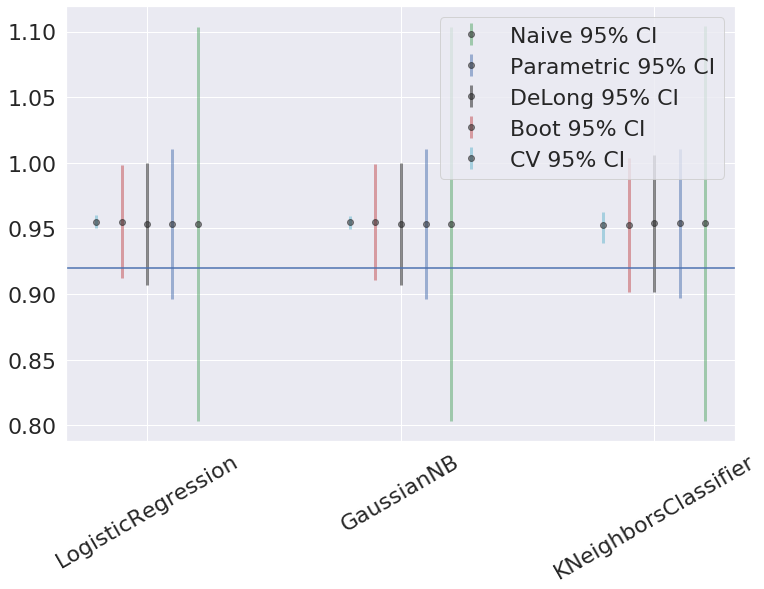

In [82]:
x = np.arange(len(aucs))
plt.figure(figsize=(12, 8))

plt.errorbar(x + 0.2, aucs, 2 * auc_var_naives, fmt='ok', lw=3, alpha=0.5, 
             ecolor='g', label='Naive 95% CI')
plt.errorbar(x + 0.1, aucs, 2 * auc_var_params, fmt='ok', lw=3, alpha=0.5, 
             ecolor='b', label='Parametric 95% CI')
plt.errorbar(x, aucs, 2 * auc_var_delongs, fmt='ok', lw=3, alpha=0.5, 
             ecolor='k', label='DeLong 95% CI')
plt.errorbar(x - 0.1, aucs_cv_means, 2 * auc_var_boots, fmt='ok', lw=3, alpha=0.5, 
             ecolor='r', label='Boot 95% CI')
plt.errorbar(x - 0.2, aucs_cv_means, np.array([aucs_cv_means - auc_ci_lows, auc_ci_highs - aucs_cv_means]), fmt='ok', lw=3, alpha=0.5, ecolor='c', label='CV 95% CI')

plt.axhline(0.92)

plt.xticks(x, model_names, rotation=30)
plt.legend()
plt.show()

## Посчитаем capture rate для `GaussianNB`

In [83]:
model = models["GaussianNB"]

In [85]:
from tqdm import trange

auc_var_naives = []
auc_var_params = []
auc_var_delongs = []
auc_var_boots = []
auc_ci_lows = []
auc_ci_highs = []
aucs_cv_means = []
aucs = []

for i in trange(100):
    X, y = make_classification(n_samples=120)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    # estimate auc and variance
    auc = roc_auc_score(y_test, y_pred)
    n, m = y_test.sum(), len(y_test) - y_test.sum()
    auc_var_naive = roc_auc_variance_from_mann_whitney(n, m)
    auc_var_param = roc_auc_variance(auc, n, m)
    _, auc_var_delong = delong_roc_variance(y_test, y_pred)
    aucs_cv_mean, auc_var_boot, (auc_ci_low, auc_ci_high) = cv_auc_var_ci(model, X, y, B=500)

    auc_var_naives.append(auc_var_naive)
    auc_var_params.append(auc_var_param)
    auc_var_delongs.append(auc_var_delong)
    auc_var_boots.append(auc_var_boot)
    auc_ci_lows.append(auc_ci_low)
    auc_ci_highs.append(auc_ci_high)
    aucs_cv_means.append(aucs_cv_mean)
    aucs.append(auc)


100%|██████████| 100/100 [08:47<00:00,  5.24s/it]

In [93]:
auc_var_naives = np.sqrt(np.array(auc_var_naives))
auc_var_params = np.sqrt(np.array(auc_var_params))
auc_var_delongs = np.sqrt(np.array(auc_var_delongs))
auc_var_boots = np.array(auc_var_boots)
auc_ci_lows = np.array(auc_ci_lows)
auc_ci_highs = np.array(auc_ci_highs)
aucs_cv_means = np.array(aucs_cv_means)
aucs = np.array(aucs)

In [94]:
((aucs - 2 * auc_var_naives < 0.92) & (0.92 < aucs + 2 * auc_var_naives)).mean()

1.0

In [95]:
((aucs - 2 * auc_var_params < 0.92) & (0.92 < aucs + 2 * auc_var_params)).mean()

1.0

In [96]:
((aucs - 2 * auc_var_delongs < 0.92) & (0.92 < aucs + 2 * auc_var_delongs)).mean()

1.0

In [97]:
((aucs_cv_means - 2 * auc_var_boots < 0.92) & (0.92 < aucs_cv_means + 2 * auc_var_boots)).mean()

1.0

In [98]:
((auc_ci_lows < 0.92) & (0.92 < auc_ci_highs)).mean()

0.27

Три проблемы:

  * Как мы увидели, классические способы оценки дисперсии AUC быстры, но дают симметричный интервал;
  * $r\times q-\mathrm{fold}$ CV даёт более красивые интервалы, но крайне дорогой по времени;
  * Для `LogisticRegression` видна некоторая смещённость оценок.

# 3. $\chi^2$-тест v.s. тест Фишера


## Постановка задачи

|  . | Мужчин | Женщин  | Всего  |
|---|---|---|---|
| Контрольная группа  | 8  |  7 |  15 |
| Инсульт  |  14 |  1 |  15 |
|  Всего  |  22 | 8  | 30  |

Мы тестируем гипотезу:

$$\mathbb{H}_0:~~\textrm{Пропорции мужчин и женщин в каждой группе равны(независимы от пола)}$$  $$~~\mathrm{vs}~~$$  $$\mathbb{H}_1: ~~ \textrm{не равны}$$

Тест считает все возможные способы разбросать 30 наблюдений по таблице 2 x 2 с такими же суммами по строкам и столбцам и с такими же пропорциями, как в таблице выше.


## Точный тест Фишера 

Цитата с Вики:


Точный тест(англ. exact test) — такой статистический критерий, при котором в ходе проверки гипотезы вероятность ошибки первого рода всегда равна уровню значимости. Соответственно, можно рассчитать точное p-значение (англ. exact p-value).



|  . | Наблюдения 1 | Наблюдения 2  | Всего в группе   |
|-----|-----|-----|-------|
| Группа 1  | $n_{11}$  |  $n_{12}$ | $n_{11} + n_{12}$ |
| Группа 2  |  $n_{21}$ |  $n_{22}$ | $n_{21} + n_{22}$ |
|  Всего  |  $n_{11} + n_{21}$ | $n_{12} + n_{22}$ | $n_{11} + n_{21} + n_{12} + n_{22}$  |


$$p = \frac{ C_{n_{11} + n_{12}}^{c_{11}} C_{n_{21} + n_{22}}^{c_{21}} }{ C_{n_{11} + n_{12} + n_{21} + n_{22}}^{ n_{11} + n_{21} } }$$




In [92]:
from scipy.stats import fisher_exact

con_m, con_f = 8, 7
str_m, str_f = 14, 14

design_matrix = np.array([[con_m, con_f], [str_m, str_f]])

oddsratio, pvalue = fisher_exact(design_matrix)


print('Fisher exact test p-value: {:.4f}'.format(pvalue))

Fisher exact test p-value: 1.0000


## $\chi^2$-тест

$$\chi^2 = \sum\limits_{i,j} \frac{(E_{ij} - O_{ij})^2}{E_{ij}},$$

где $O_{ij}$ - число в ячейке $ij$, $E_{ij}$ - математическое ожидание числа наблюдений при нулевой гипотезе.

In [52]:
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(design_matrix, correction=True)

print('Chi2 test p-value: {:.4f}'.format(p))

Chi2 test p-value: 0.0390


In [53]:
chi2

4.261363636363637

In [54]:
E = (np.outer(design_matrix.sum(axis=1), design_matrix.sum(axis=0)) / 30)

In [55]:
((np.abs(E - design_matrix) - 0.5)**2 / E).sum()

4.261363636363637

In [56]:
from scipy.stats import chi2

In [57]:
1 - chi2.cdf(((np.abs(E - design_matrix) - 0.5)**2 / E).sum(), df=1)

0.03898861209635851